In [17]:
import tensorflow as tf
import multiprocessing as mp
import matplotlib.pyplot as plt
import os

In [18]:
from keras import backend as K
# tf.config.set_visible_devices([], 'GPU') # für CPU usage
config = tf.compat.v1.ConfigProto(device_count = {'GPU': len(tf.config.list_physical_devices('GPU')), # sollte 1 sein, weil wir nur eine GPU haben
                                                  'CPU': mp.cpu_count()})                             # sollte 64 sein, weil wir 64 CPU Kerne haben
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

2023-06-09 17:11:07.685702: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78918 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c0:00.0, compute capability: 8.0


### Paths

In [19]:
DATASET_PATH = "/scratch/schneialexan/dataset/"

TEST_PATH = DATASET_PATH + "test/"
TRAIN_PATH = DATASET_PATH + "train/"
VAL_PATH = DATASET_PATH + "val/"

In [20]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    # Plot training and validation accuracy per epoch
    ax1.plot(epochs, acc, 'bo', label='Training acc')
    ax1.plot(epochs, val_acc, 'r-', label='Validation acc')
    ax1.set_title('Training and validation accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    # Plot training and validation loss per epoch
    ax2.plot(epochs, loss, 'bo', label='Training loss')
    ax2.plot(epochs, val_loss, 'r-', label='Validation loss')
    ax2.set_title('Training and validation loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    return fig

### Data Exploration

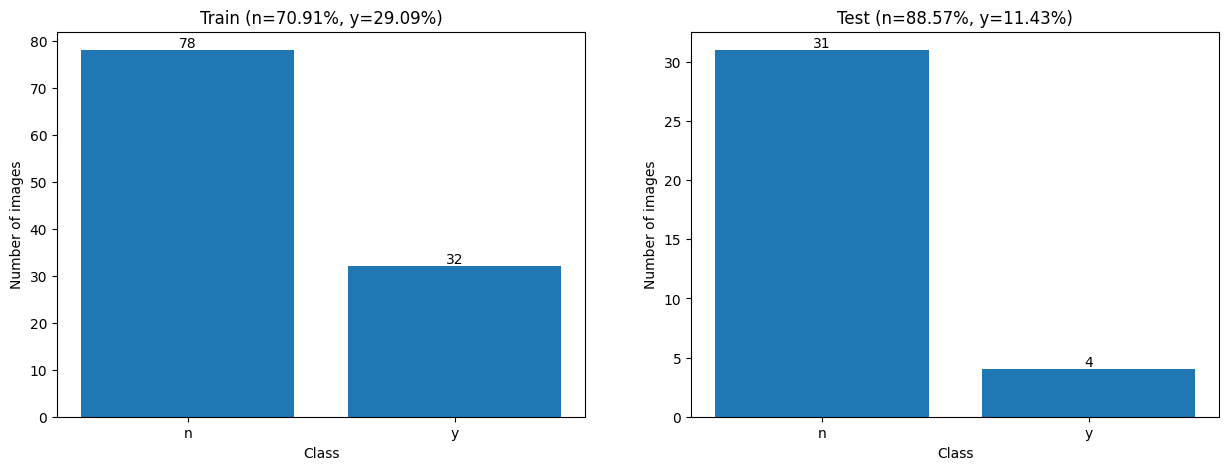

In [21]:
# make bar chart with number of n and y for test and train
nmbr_of_n_train = len(os.listdir(TRAIN_PATH + "n"))
nmbr_of_y_train = len(os.listdir(TRAIN_PATH + "y"))
nmbr_of_n_test = len(os.listdir(TEST_PATH + "n"))
nmbr_of_y_test = len(os.listdir(TEST_PATH + "y"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.bar(["n", "y"], [nmbr_of_n_train, nmbr_of_y_train])
ax1.set_title(f"Train (n={(100*nmbr_of_n_train)/(nmbr_of_n_train+nmbr_of_y_train):.2f}%, y={(100*nmbr_of_y_train)/(nmbr_of_n_train+nmbr_of_y_train):.2f}%)")
ax1.set_xlabel("Class")
ax1.set_ylabel("Number of images")
ax1.text(0, nmbr_of_n_train, nmbr_of_n_train, ha='center', va='bottom')
ax1.text(1, nmbr_of_y_train, nmbr_of_y_train, ha='center', va='bottom')
ax2.bar(["n", "y"], [nmbr_of_n_test, nmbr_of_y_test])
ax2.set_title(f"Test (n={(100*nmbr_of_n_test)/(nmbr_of_n_test+nmbr_of_y_test):.2f}%, y={(100*nmbr_of_y_test)/(nmbr_of_n_test+nmbr_of_y_test):.2f}%)")
ax2.set_xlabel("Class")
ax2.set_ylabel("Number of images")
ax2.text(0, nmbr_of_n_test, nmbr_of_n_test, ha='center', va='bottom')
ax2.text(1, nmbr_of_y_test, nmbr_of_y_test, ha='center', va='bottom')
plt.show()

### Data Generation

In [22]:
TARGET_SIZE = (1000, 1000)  # Image Size is (1250, 1250) - but sadly this crashes the kernel
EPOCHS = 20
BATCH_SIZE = 4

In [23]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(TRAIN_PATH,
                                       target_size = TARGET_SIZE,
                                       batch_size = BATCH_SIZE,
                                       class_mode = 'binary')
val_gen = datagen.flow_from_directory(TEST_PATH,
                                      target_size = TARGET_SIZE,
                                      batch_size = BATCH_SIZE,
                                      class_mode = 'binary')

Found 110 images belonging to 2 classes.
Found 35 images belonging to 2 classes.


### Base Model

In [24]:
def base_model():
    model = tf.keras.models.Sequential()
    # CNN Block 1
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(TARGET_SIZE[0],TARGET_SIZE[1],3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Dropout(0.2))
    # Classification Block
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model
baseline_model = base_model()
baseline_model.compile(loss = 'binary_crossentropy',
                       optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                       metrics=['acc'])
baseline_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 998, 998, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 499, 499, 32)     0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 499, 499, 32)      0         
                                                                 
 flatten_2 (Flatten)         (None, 7968032)           0         
                                                                 
 dense_4 (Dense)             (None, 64)                509954112 
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                      

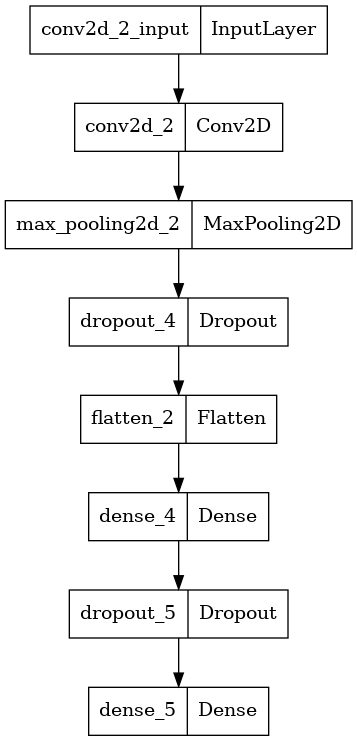

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(baseline_model)

In [26]:
baseline_history = baseline_model.fit(
        train_gen,
        epochs = EPOCHS,
        validation_data=val_gen
    )

Epoch 1/20


2023-06-09 17:11:09.089062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-09 17:11:09.400611: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


28/28 [==============================] - ETA: 0s - loss: 1.3624 - acc: 0.6455

2023-06-09 17:11:14.830518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


28/28 [==============================] - 8s 271ms/step - loss: 1.3624 - acc: 0.6455 - val_loss: 0.5212 - val_acc: 0.8857
Epoch 2/20
28/28 [==============================] - 9s 312ms/step - loss: 0.6487 - acc: 0.6636 - val_loss: 0.4637 - val_acc: 0.8857
Epoch 3/20
28/28 [==============================] - 9s 318ms/step - loss: 0.6432 - acc: 0.6909 - val_loss: 0.5293 - val_acc: 0.8857
Epoch 4/20
28/28 [==============================] - 8s 300ms/step - loss: 0.6360 - acc: 0.7182 - val_loss: 0.6051 - val_acc: 0.8857
Epoch 5/20
28/28 [==============================] - 9s 310ms/step - loss: 0.6013 - acc: 0.6636 - val_loss: 0.6303 - val_acc: 0.8571
Epoch 6/20
28/28 [==============================] - 8s 301ms/step - loss: 0.5874 - acc: 0.7364 - val_loss: 0.4952 - val_acc: 0.8857
Epoch 7/20
28/28 [==============================] - 9s 324ms/step - loss: 0.5405 - acc: 0.7182 - val_loss: 0.5419 - val_acc: 0.8857
Epoch 8/20
28/28 [==============================] - 9s 314ms/step - loss: 0.5405 - acc:

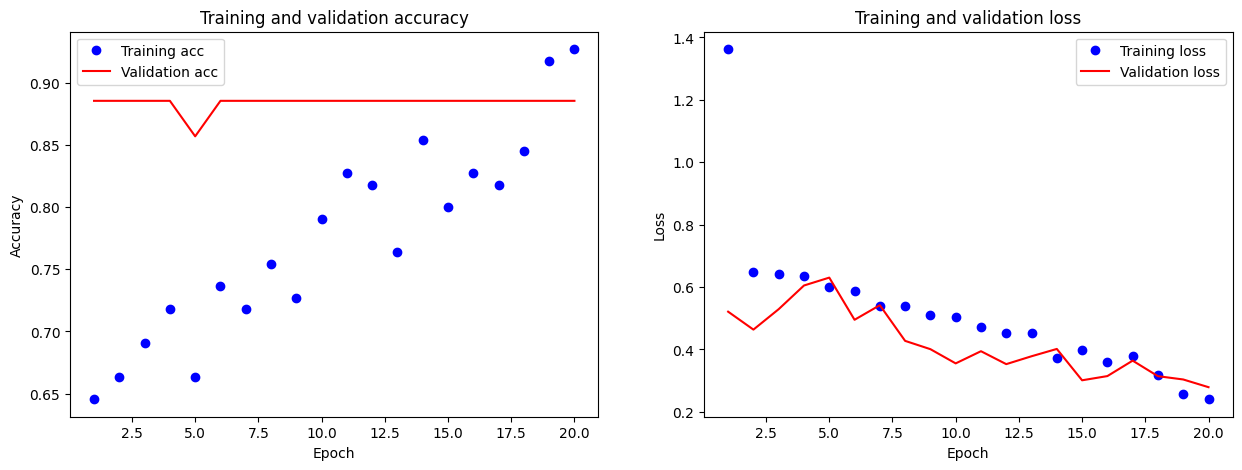

In [27]:
plot_history(baseline_history);

#### Erkenntnis: <br>
aktuell wird nur nein predicted, also müssen mehr daten generiert werden.

### Optimierung mit Data Augmentation

In [28]:
# Define the augmentation parameters
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # Randomly rotate images within 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2, # Randomly shift images vertically
    shear_range=0.2,        # Apply shearing transformation
    zoom_range=0.2,         # Apply zooming transformation
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest'     # Fill any newly created pixels after rotation or shifting
)

datagen_val = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_gen = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_gen = datagen_val.flow_from_directory(
    TEST_PATH,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 110 images belonging to 2 classes.
Found 35 images belonging to 2 classes.


In [29]:
nr2_baseline_model = base_model()
nr2_baseline_model.compile(loss = 'binary_crossentropy',
                       optimizer=tf.keras.optimizers.RMSprop(),
                       metrics=['mse', 'acc'])
nr2_baseline_history = nr2_baseline_model.fit(
        train_gen,
        epochs = EPOCHS,
        validation_data=val_gen
    )

Epoch 1/20


2023-06-09 17:14:05.383046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-09 17:14:05.869517: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


28/28 [==============================] - ETA: 0s - loss: 174.8273 - mse: 0.4159 - acc: 0.5455

2023-06-09 17:14:25.669545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


28/28 [==============================] - 23s 767ms/step - loss: 174.8273 - mse: 0.4159 - acc: 0.5455 - val_loss: 1.0983 - val_mse: 0.1143 - val_acc: 0.8857
Epoch 2/20
28/28 [==============================] - 21s 743ms/step - loss: 1.9554 - mse: 0.2568 - acc: 0.7091 - val_loss: 0.9269 - val_mse: 0.3375 - val_acc: 0.6000
Epoch 3/20
28/28 [==============================] - 20s 720ms/step - loss: 4.2238 - mse: 0.2482 - acc: 0.7000 - val_loss: 0.8775 - val_mse: 0.3213 - val_acc: 0.6571
Epoch 4/20
28/28 [==============================] - 22s 769ms/step - loss: 2.2474 - mse: 0.2610 - acc: 0.7091 - val_loss: 1.0242 - val_mse: 0.3600 - val_acc: 0.4857
Epoch 5/20
28/28 [==============================] - 22s 780ms/step - loss: 0.7662 - mse: 0.2462 - acc: 0.7182 - val_loss: 0.6670 - val_mse: 0.2369 - val_acc: 0.8857
Epoch 6/20
28/28 [==============================] - 20s 714ms/step - loss: 0.6778 - mse: 0.2423 - acc: 0.7091 - val_loss: 0.6606 - val_mse: 0.2338 - val_acc: 0.8857
Epoch 7/20
28/28 [=

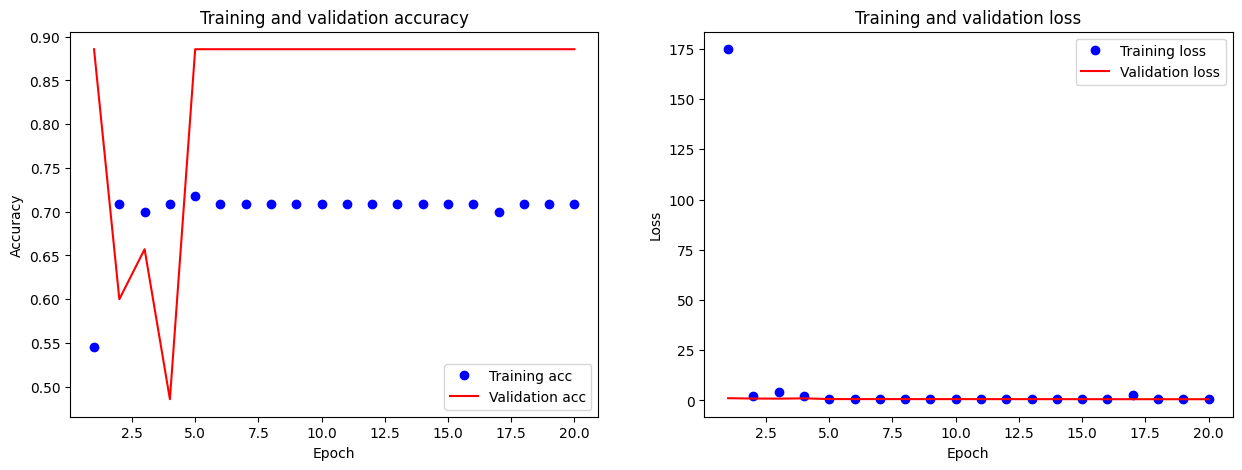

In [30]:
plot_history(nr2_baseline_history);

#### Erkenntnis: <br>
Auch mit data augmentation wird immernoch immer 'n' vorhergesagt, zudem lieg die train accuracy tiefer als die validierungs accuracy. das könnte auf ein overfitting deuten. Deswegen wird im nächsten Schritt das Modell vereinfacht.